First, let's check the correlation matrix

                    Year   LE_both   LE_male  LE_female  GDP per Capita  \
Year            1.000000  0.190830  0.198597   0.180009        0.146334   
LE_both         0.190830  1.000000  0.992158   0.993733        0.589619   
LE_male         0.198597  0.992158  1.000000   0.972655        0.610144   
LE_female       0.180009  0.993733  0.972655   1.000000        0.562067   
GDP per Capita  0.146334  0.589619  0.610144   0.562067        1.000000   
CHE_in_USD      0.147424  0.545385  0.560186   0.520355        0.915455   

                CHE_in_USD  
Year              0.147424  
LE_both           0.545385  
LE_male           0.560186  
LE_female         0.520355  
GDP per Capita    0.915455  
CHE_in_USD        1.000000  


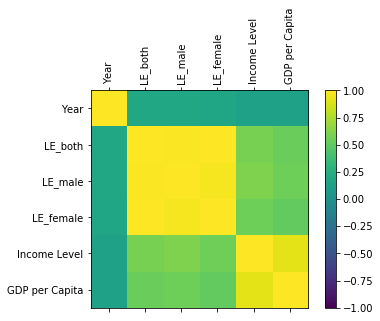

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('data/processed/merged_data.csv')
# rename columns for convenience
data.rename(index=str, columns={'Life expectancy at birth (years)  Both sexes': 'LE_both'}, inplace=True)
data.rename(index=str, columns={'Life expectancy at birth (years)  Male': 'LE_male'}, inplace=True)
data.rename(index=str, columns={'Life expectancy at birth (years)  Female': 'LE_female'}, inplace=True)
data.rename(columns={data.columns[7]: 'CHE_in_USD'}, inplace=True)
data.rename(columns={data.columns[8]: 'RnD_ex_pct'}, inplace=True)
#
#print(data['RnD_ex_pct'])
#
correlations = data.corr()
print(correlations)
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

As we can see this is not satisfactoring result, there is no strong correlation between GDP and life expectancy at birth. So let's look at a scatter plot and check if there is at least some linear relation between these variables.

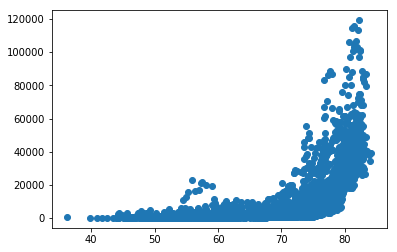

In [22]:
from pandas.plotting import scatter_matrix
#scatter_matrix(data)
#plt.show()
# show simple scatter plot
plt.scatter(data["LE_both"], data["GDP per Capita"])